In [632]:
import pandas as pd
import pylab as pl
pd.set_option('display.max_columns', 500)

In [633]:
data = pd.read_csv('data/music_data_merged_spotify.csv', low_memory=False, index_col=False)
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [634]:
tracks_data = data[data.type == 'track'].reset_index(drop = True)

In [635]:
len(tracks_data.ISRC.unique())

999

# clean data

In [636]:
#Statement Month to datetime
tracks_data['Statement Month'] = pd.to_datetime(tracks_data['Statement Month'])

#Gross Revenue to float
tracks_data['Gross Revenue USD'] = tracks_data[
    'Gross Revenue USD'
].str.replace(
    '$',''
).str.replace(
    ',',''
).astype('float')

#Net Revenue to float
tracks_data['Net Revenue USD'] = tracks_data[
    'Net Revenue USD'
].str.replace('$','').str.replace(',','').astype('float')

#Units to int
tracks_data['Units'] = tracks_data['Units'].str.replace(',','').astype('int')

/var/folders/h6/ctf2k5q1565986t2npwvzf0w0000gn/T/ipykernel_34434/2632885198.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tracks_data['Gross Revenue USD'] = tracks_data[
/var/folders/h6/ctf2k5q1565986t2npwvzf0w0000gn/T/ipykernel_34434/2632885198.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tracks_data['Net Revenue USD'] = tracks_data[


# descriptive

In [637]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sns.set_style('whitegrid')

In [638]:
features = ['danceability','energy','loudness','speechiness', #'track_popularity',
            'acousticness','instrumentalness','liveness','valence','tempo']

clean_tracks_data = tracks_data[
    (tracks_data['Gross Revenue USD'] > 0) &
    ~(tracks_data.spotify_id.isna())
].dropna(
    subset = features,
    how = 'any'
).reset_index(drop = True)

clean_tracks_data['gross_rev'] = clean_tracks_data['Gross Revenue USD']

In [639]:
clean_tracks_data['date_coalesce'] = np.where(
    clean_tracks_data.track_release_date_precision == 'day',
    clean_tracks_data.track_release_date,
    np.where(
        ((clean_tracks_data.track_release_date_precision == 'year') &
        (clean_tracks_data.album_release_date_precision == 'day')),
        clean_tracks_data.album_release_date,
        clean_tracks_data.track_release_date.astype('string')
    )
)

clean_tracks_data['date_coalesce'] = clean_tracks_data['date_coalesce'].astype('string')

clean_tracks_data['date'] = clean_tracks_data.date_coalesce.apply(lambda x: x if len(x) > 4 else x + '-01-01')
clean_tracks_data['date'] = pd.to_datetime(clean_tracks_data.date)

today_date = pd.to_datetime('2021-12-05')

clean_tracks_data['diff_days'] = today_date - clean_tracks_data['date']
clean_tracks_data['months_since_release'] = clean_tracks_data['diff_days'] / np.timedelta64(1, 'M')

In [640]:
sum_rev_df = clean_tracks_data[['spotify_id','gross_rev', 'months_since_release'] + features].groupby(
    ['spotify_id', 'months_since_release'] + features
).sum().reset_index()

In [641]:
sum_rev_df['gross_rev_by_month'] = sum_rev_df.gross_rev / sum_rev_df.months_since_release

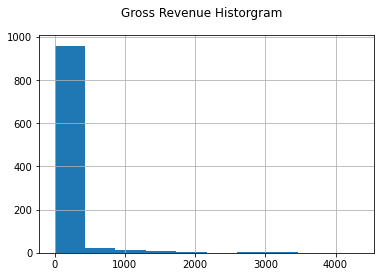

In [642]:
axes = sum_rev_df.gross_rev_by_month.hist()
pl.suptitle("Gross Revenue Historgram");

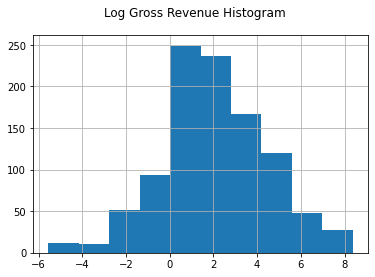

In [643]:
sum_rev_df['log_rev'] = np.log(sum_rev_df['gross_rev_by_month'])

axes = sum_rev_df.log_rev.hist()
pl.suptitle("Log Gross Revenue Histogram");

/var/folders/h6/ctf2k5q1565986t2npwvzf0w0000gn/T/ipykernel_34434/383143621.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  sum_rev_df[features].hist(ax = ax)


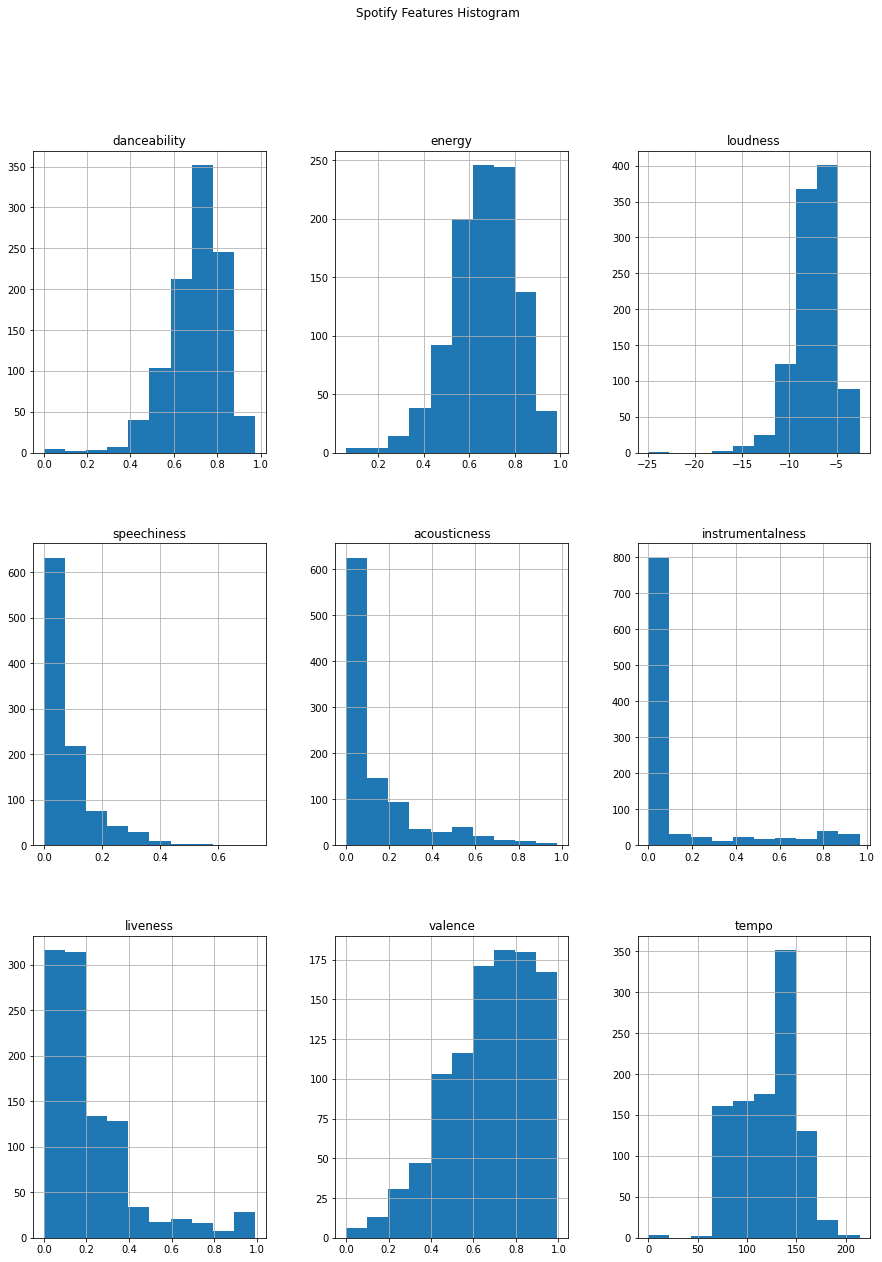

In [644]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
sum_rev_df[features].hist(ax = ax)
pl.suptitle(f"Spotify Features Histogram");

In [645]:
sum_rev_df.instrumentalness = np.where(
    sum_rev_df.instrumentalness == 0,
    .000001,
    sum_rev_df.instrumentalness
)
sum_rev_df.instrumentalness = np.log(sum_rev_df.instrumentalness)

sum_rev_df.speechiness = np.where(
    sum_rev_df.speechiness == 0,
    .000001,
    sum_rev_df.speechiness
)
sum_rev_df.speechiness = np.log(sum_rev_df.speechiness)

sum_rev_df.acousticness = np.where(
    sum_rev_df.acousticness == 0,
    .000001,
    sum_rev_df.acousticness
)
sum_rev_df.acousticness = np.log(sum_rev_df.acousticness)

/var/folders/h6/ctf2k5q1565986t2npwvzf0w0000gn/T/ipykernel_34434/947504831.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  sum_rev_df[['speechiness','acousticness','instrumentalness']].hist(ax = ax)


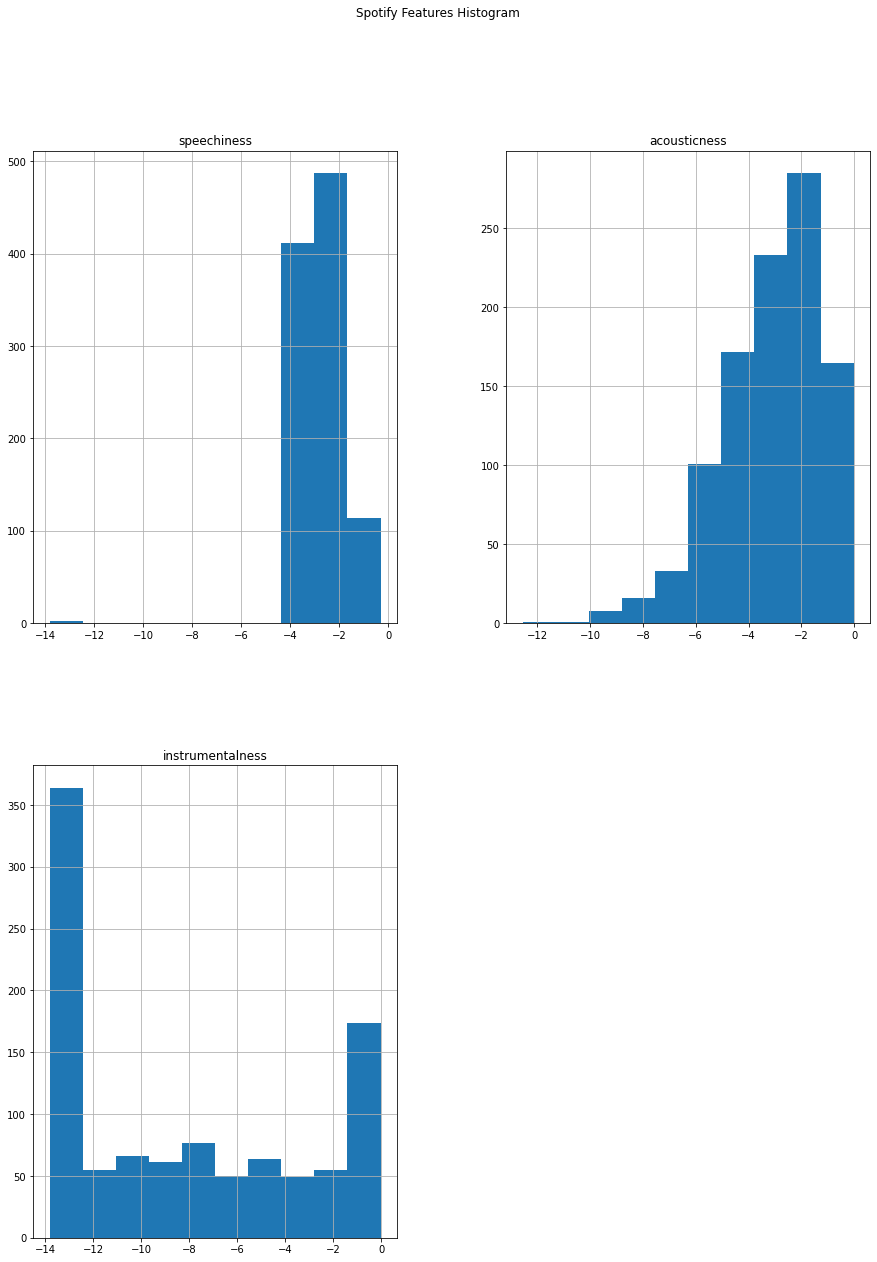

In [709]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
sum_rev_df[['speechiness','acousticness','instrumentalness']].hist(ax = ax)
pl.suptitle(f"Spotify Features Histogram");

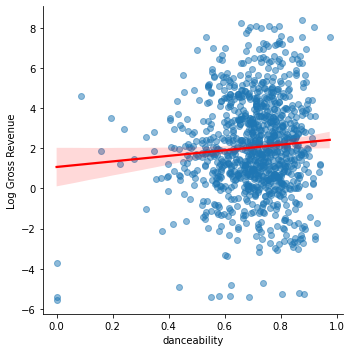

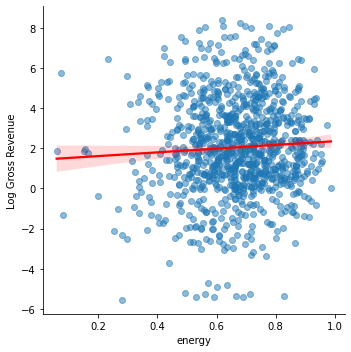

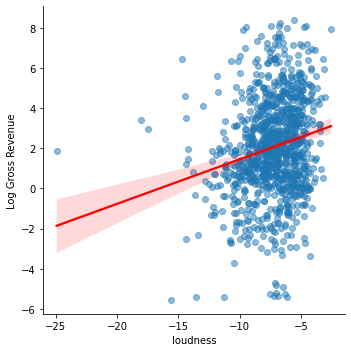

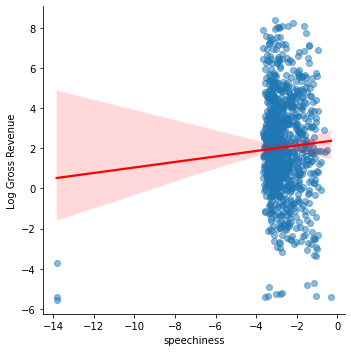

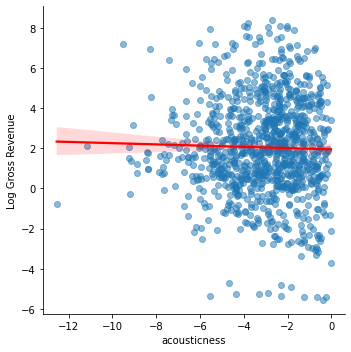

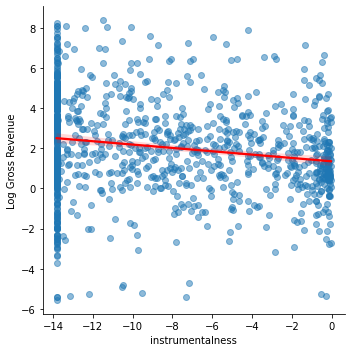

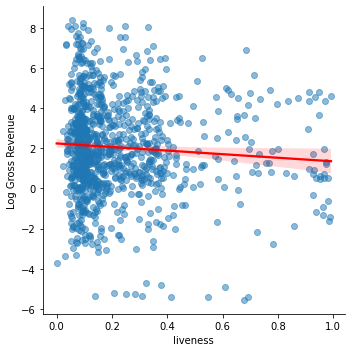

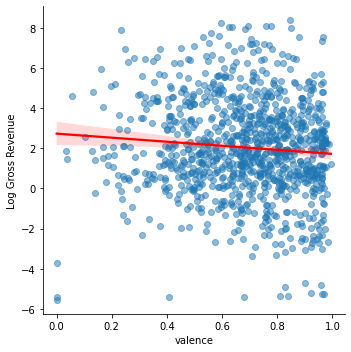

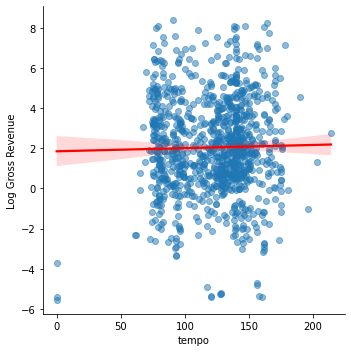

In [647]:
for feat in features:
    ax = sns.lmplot(x = feat,
               y = 'log_rev',
               data = sum_rev_df,
               scatter_kws={'alpha':0.5},
               line_kws={'color': 'red'},
               fit_reg = True)
    ax.set(ylabel='Log Gross Revenue')

# regression

In [648]:
import numpy as np
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [649]:
y = sum_rev_df['log_rev']

In [650]:
def get_stats():
    x = sum_rev_df[features]
#     x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    print(results.summary(title = 'OLS Regression Results: Full Model'))
get_stats()

                           OLS Regression Results: Full Model                          
Dep. Variable:                log_rev   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.467
Method:                 Least Squares   F-statistic:                              99.62
Date:                Mon, 06 Dec 2021   Prob (F-statistic):                   1.14e-132
Time:                        13:09:26   Log-Likelihood:                         -2286.4
No. Observations:                1015   AIC:                                      4591.
Df Residuals:                    1006   BIC:                                      4635.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

An acceptable VIF is if it’s less than the max of 10 and 1/1-R²model (see below):

In [651]:
1/(1-0.898)

9.803921568627453

In [652]:
# valence, danceability, loudness, energy
vif_data = pd.DataFrame()
vif_data["feature"] = features

X = sum_rev_df[features]

In [653]:
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [654]:
vif_data.style.set_caption("VIF Table: Full Model")

# vif_data

,feature,VIF
0,danceability,29.628234
1,energy,25.680197
2,loudness,11.859184
3,speechiness,9.130101
4,acousticness,4.208172
5,instrumentalness,3.637485
6,liveness,2.568805
7,valence,16.967870
8,tempo,17.789369


A lot of our variables show multicollinearity here. let's see which are corrlated

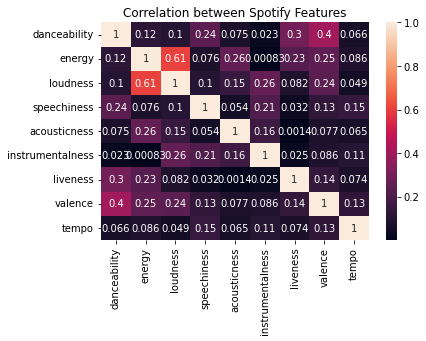

In [655]:
ax = plt.axes()

sns.heatmap(sum_rev_df[features].corr().abs(),
            annot=True, ax = ax)

ax.set_title('Correlation between Spotify Features')
plt.show();

In [656]:
# loudness & energy
# valence & danceability

In [719]:
features_reduced = features.copy()
features_reduced.remove('danceability')
features_reduced.remove('energy')
features_reduced.remove('valence')
features_reduced.remove('loudness')
features_reduced.remove('tempo')
features_reduced.remove('speechiness')

In [720]:
x = sum_rev_df[features_reduced]
# x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
print(results.summary(title = 'OLS Regression Result: Reduced Model'))

                          OLS Regression Result: Reduced Model                         
Dep. Variable:     gross_rev_by_month   R-squared (uncentered):                   0.093
Model:                            OLS   Adj. R-squared (uncentered):              0.090
Method:                 Least Squares   F-statistic:                              34.60
Date:                Mon, 06 Dec 2021   Prob (F-statistic):                    2.74e-21
Time:                        13:39:32   Log-Likelihood:                         -7495.0
No. Observations:                1015   AIC:                                  1.500e+04
Df Residuals:                    1012   BIC:                                  1.501e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [722]:
# valence, danceability, loudness, energy
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = features_reduced

X = sum_rev_df[features_reduced]
vif_data_reduced["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
vif_data_reduced.style.set_caption("VIF Table: Reduced Model")

,feature,VIF
0,acousticness,2.142502
1,instrumentalness,2.172541
2,liveness,1.939718


In [660]:
1/(1-.415)

1.7094017094017095

In [667]:
features_reduced2 = features_reduced.copy()
features_reduced2.remove('speechiness')
features_reduced2.remove('liveness')

x = sum_rev_df[features_reduced2]
# x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
print(results.summary(title = 'OLS Regression Result: Final Model'))

                           OLS Regression Result: Final Model                          
Dep. Variable:                log_rev   R-squared (uncentered):                   0.436
Model:                            OLS   Adj. R-squared (uncentered):              0.434
Method:                 Least Squares   F-statistic:                              260.7
Date:                Mon, 06 Dec 2021   Prob (F-statistic):                   2.51e-125
Time:                        13:10:58   Log-Likelihood:                         -2319.2
No. Observations:                1015   AIC:                                      4644.
Df Residuals:                    1012   BIC:                                      4659.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [809]:
sum_rev_df

,spotify_id,months_since_release,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,gross_rev,gross_rev_by_month,log_rev
0,006UfnCaMAjqkEhQHRMYan,53.192057,0.632,0.840,-5.579,-1.973281,-4.213128,-13.815511,0.3070,0.635,89.994,63.03,1.184951,0.169702
1,00FOaeL2apSd74TsPPehls,85.718393,0.762,0.712,-8.690,-3.203987,-6.331142,-13.815511,0.1470,0.694,140.056,125.02,1.458497,0.377406
2,00L8moYjvFTRgiTYSXbYow,34.333354,0.721,0.561,-10.011,-2.562652,-3.349554,-4.319991,0.1470,0.913,139.955,1270.61,37.008036,3.611135
3,01aBeZRX0kcXQRjirORgBu,80.461611,0.633,0.551,-5.523,-3.486755,-3.696912,-8.463652,0.1970,0.578,85.989,519.84,6.460721,1.865741
4,01jLFhBEOGPSCTZsUXqohD,79.968788,0.553,0.699,-7.880,-3.381395,-8.881037,-1.164752,0.3740,0.653,145.229,170.65,2.133958,0.757978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,7yPnxeocaIeYDYUVXrnejx,167.132795,0.723,0.729,-5.483,-3.079114,-3.849048,-8.785073,0.0513,0.963,82.289,280.54,1.678545,0.517928
1011,7ySdEN7DxGsSxljRnWD8eF,41.692848,0.581,0.234,-14.707,-3.657381,-1.523260,-2.820100,0.0818,0.322,75.963,26825.22,643.400999,6.466768
1012,7yrG111WyPfXr2Lp6VCPM8,287.118832,0.904,0.401,-8.912,-1.070025,-0.703198,-13.815511,0.1390,0.759,131.977,68.63,0.239030,-1.431166
1013,7zR0eefGyPgkENI2HO1NyV,99.517444,0.713,0.616,-7.256,-2.433833,-5.314447,-13.815511,0.1120,0.920,87.526,5926.23,59.549661,4.086811


In [822]:
X_train = X_train[['acousticness', 'instrumentalness', 'tempo']]
X_test = X_test[['acousticness', 'instrumentalness', 'tempo']]

In [823]:
f = sm.OLS(y_train,X_train).fit()

In [824]:
Y_pred = f.predict(X_test)

[Text(0, 0.5, 'residuals'),
 Text(0.5, 0, 'fitted values'),
 Text(0.5, 1.0, 'OLS Residuals vs Fitted')]

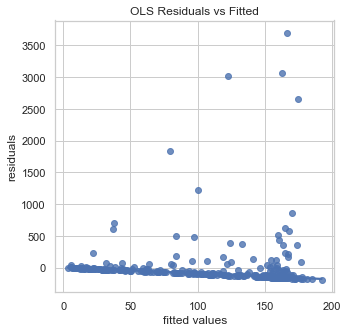

In [827]:

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize =(5,5))
sns.regplot(x=Y_pred, y=y_test-Y_pred, ax=ax,lowess=True)
ax.set(ylabel='residuals',xlabel='fitted values',title='OLS Residuals vs Fitted')

In [668]:
1/(1-.414)

1.706484641638225

In [669]:
vif_data_reduced_again2 = pd.DataFrame()
vif_data_reduced_again2["feature"] = features_reduced2

X = sum_rev_df[features_reduced2]
vif_data_reduced_again2["VIF"] = [variance_inflation_factor(X.values, i)
                                 for i in range(len(X.columns))]
vif_data_reduced_again2.style.set_caption("VIF Table: Final Model")

,feature,VIF
0,acousticness,3.386638
1,instrumentalness,2.981840
2,tempo,5.376300


# other models

In [740]:
X = sum_rev_df[features]

In [741]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [742]:
y = sum_rev_df.gross_rev_by_month

Text(0.5, 1.0, 'Gross Revenue')

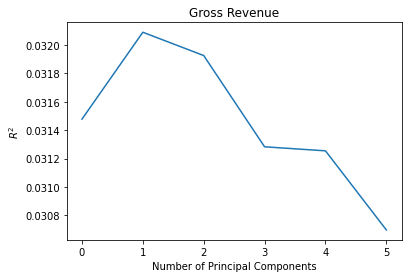

In [776]:
# scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=4, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='r2').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='r2').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('$R^2$')
plt.title('Gross Revenue')

The plot displays the number of principal components along the x-axis and the test MSE (mean squared error) along the y-axis. From the plot we can see that the test MSE decreases by adding in two principal components, yet it begins to increase as we add more than two principal components.

Thus, the optimal model includes just the first two principal components.

In [744]:
mse

[0.03147737437774499,
 0.03208886033589188,
 0.031924831198835955,
 0.031282698108102525,
 0.03125428909036695,
 0.03069774851439817]

In [777]:
d = pd.DataFrame(
    {'Components': [str(x) + ' Components' for x in range(1,10)],
    'Explained Variance': list(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))}
)
d.style.set_caption("Components Explained Variance")

,Components,Explained Variance
0,1 Components,21.930000
1,2 Components,40.820000
2,3 Components,55.040000
3,4 Components,66.140000
4,5 Components,76.000000
5,6 Components,84.500000
6,7 Components,91.040000
7,8 Components,97.000000
8,9 Components,99.990000


We can also use the following code to calculate the percentage of variance in the response variable explained by adding in each principal component to the model (above). We can see the following:

By using just the first principal component, we can explain 69.83% of the variation in the response variable.
By adding in the second principal component, we can explain 89.35% of the variation in the response variable.
Note that we’ll always be able to explain more variance by using more principal components, but we can see that adding in more than two principal components doesn’t actually increase the percentage of explained variance by much.

In [778]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

TypeError: 'numpy.float64' object is not callable

In [785]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

PLSRegression(n_components=3)

In [786]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.008
PLS r-squared 0.048


# ridge

In [749]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [750]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [751]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)


(100, 9)

Text(0, 0.5, 'weights')

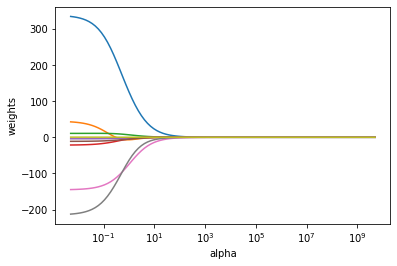

In [752]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


In [753]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [754]:
# ridge2 = Ridge(alpha = 4, normalize = True)
# ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
# pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
# print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
# print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

In [755]:
# ridge3 = Ridge(alpha = 10**5, normalize = True)
# ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
# pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
# print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
# print(mean_squared_error(y_test, pred3))          # Calculate the test MSE


In [756]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'r2', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.18824679033962358

In [757]:
ridgebest = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgebest.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

1851402.3682511635

In [758]:
pred_train_rr= ridgebest.predict(X_train)
print((mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= ridgebest.predict(X_test)
print((mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

136745.508095569
0.03387089450412095
181071.22055704935
0.04157488975257606


In [759]:
ridgebest.fit(X, y)
d = pd.DataFrame({'feature': X.columns,'coefficient': ridgebest.coef_})
d.style.set_caption("Ridge Regression Coefficients")

,feature,coefficient
0,danceability,246.067273
1,energy,7.151439
2,loudness,10.413161
3,speechiness,-14.037882
4,acousticness,-3.649850
5,instrumentalness,-9.046606
6,liveness,-122.848841
7,valence,-150.922626
8,tempo,0.239807


In [760]:
ridgebest.score(X,y)

0.041185248123574936

# lasso

Text(0, 0.5, 'weights')

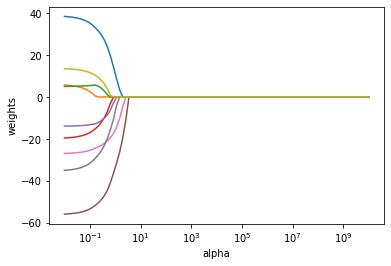

In [761]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [762]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

181055.97748169163

In [763]:
r2_score(y_test, lasso.predict(X_test))
r2_score(y_train, lasso.predict(X_train))

0.04165557262495789

0.034344483562166794

In [765]:
# Some of the coefficients are now reduced to exactly zero.
d = pd.DataFrame({'feature': X.columns,'coefficient': lasso.coef_})
d.style.set_caption("Lasso Regression Coefficients")

,feature,coefficient
0,danceability,228.772417
1,energy,0.000000
2,loudness,2.083763
3,speechiness,-12.170192
4,acousticness,-5.916201
5,instrumentalness,-9.614159
6,liveness,-111.397712
7,valence,-124.973915
8,tempo,0.272934


In [766]:
lasso.score(X, y)

0.03768768202711148

In [767]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [768]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = np.absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [769]:
enet_cv_model = ElasticNetCV(cv = 10).fit(X_train,y_train)

In [770]:
enet_cv_model.l1_ratio_

0.5

In [771]:
# Train the model
e_net = ElasticNet(alpha = enet_cv_model.alpha_, l1_ratio=.5)
e_net.fit(X_train, y_train)
 
# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(X_test)
y_pred_train_elastic = e_net.predict(X_train)

mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("Mean Squared Error on test set", mean_squared_error)
 
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = X_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff.style.set_caption("Elastic Net Coefficients")

Mean Squared Error on test set 185480.64489137984


,Columns,Coefficient Estimate
0,danceability,0.000000
1,energy,-0.000000
2,loudness,0.219148
3,speechiness,-0.447791
4,acousticness,-2.159632
5,instrumentalness,-7.474139
6,liveness,-0.112656
7,valence,-0.000000
8,tempo,0.305447


In [772]:
print(r2_score(y_test,y_pred_elastic))
print(r2_score(y_train,y_pred_train_elastic))

0.018235438067448206
0.015962920036778128


In [773]:
e_net.score(X,y)

0.017484152340059733

In [774]:
X.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [802]:
d = pd.DataFrame({
    'lasso': lasso.coef_,
    'ridge':ridgebest.coef_,
    'elastic net': e_net.coef_
}, index = X.columns)
d.style.set_caption("Regression Coefficients")

,lasso,ridge,elastic net
danceability,228.772417,246.067273,0.000000
energy,0.000000,7.151439,-0.000000
loudness,2.083763,10.413161,0.219148
speechiness,-12.170192,-14.037882,-0.447791
acousticness,-5.916201,-3.649850,-2.159632
instrumentalness,-9.614159,-9.046606,-7.474139
liveness,-111.397712,-122.848841,-0.112656
valence,-124.973915,-150.922626,-0.000000
tempo,0.272934,0.239807,0.305447


In [797]:
r = {'Ridge': [ridgebest.score(X, y),
     r2_score(y_train, ridgebest.predict(X_train)),
     r2_score(y_test, ridgebest.predict(X_test))],

 'Lasso':[lasso.score(X, y),
                r2_score(y_train, lasso.predict(X_train)),
                r2_score(y_test, lasso.predict(X_test))],

 
 'Elastic Net': [e_net.score(X,y),
     r2_score(y_train,y_pred_train_elastic),
     r2_score(y_test,y_pred_elastic)]}



In [801]:
s = pd.DataFrame(r, index = ['Overall', 'Train', 'Test'])
s.style.set_caption("R-Squared Values")

,Ridge,Lasso,Elastic Net
Overall,0.041185,0.037688,0.017484
Train,0.034905,0.030736,-0.011185
Test,0.053747,0.051615,0.002655


In [ ]:
sns.residplot()